In [123]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import evosax

from typing import NamedTuple
from functools import partial
import math
import json

In [125]:
import xylo
import xylo.types as t
import xylo.woods
import xylo.cut

import xylo.receptance as r
import xylo.sweep as xs

import xylo.loss.receptance as xlr

import xylo.tuning

In [126]:
tuning = xylo.tuning.yamaha_YX500R

In [127]:
note = 59

bar_default = t.BarProps(width = 0.038, depth = 0.019, length = tuning.note_to_length(note), elements = 300, min_depth = 0.010)
fundamental = tuning.note_to_freq(note) # / 1.5

# wood = xylo.woods.spotted_gum
wood = t.Wood.make_E_nu(E = 29.100e9, nu = 8.20, rho = 1059)

# weights = jnp.array([[1, -1.0]])
# weights = jnp.array([[3, -0.75]])
# weights = jnp.array([[1, -1.0], [3, -1.0]])
# weights = jnp.array([[1, -1.0], [1.1, 1.0], [3, -1.0], [3.3, 1.0]])
# weights = jnp.array([[1, -1.0], [3, -0.75], [6, -0.5]])
# weights = jnp.array([[0.5, 0.1], [1, -1.0], [2, 0.1], [3, -0.75], [4, 0.1], [6, -0.5]])
# weights = jnp.array([[1, -1.0]])
# weights = jnp.array([[0.9, 0.1], [1, -1.0], [1.1, 0.1], [2.9, 0.075], [3, -0.75], [3.1, 0.075], [5.9, 0.05], [6, -0.5], [6.1, 0.05]])

# weights = jnp.array([[1, -1.0], [0.9, 1.0]]) # , [3, -0.9], [2.9, 0.9], [6, -0.8], [5.9, 0.8]])

# weights = jnp.array([[1, -1.0], [0.9, 1.0], [3, -0.9], [2.9, 0.9], [6, -0.8], [5.9, 0.8]])
# weights = jnp.array([[0.5, 1.0], [0.75, 1.0], [1, -1.0], [0.9, 1.0], [1.1, -1.0], [3, -0.9], [2.9, 0.9], [3.1, -0.9], [6, -0.8], [5.9, 0.8], [6.1, -0.8]])

# weights = jnp.array([[0.1, 1.0], [0.2, 1.0], [0.3, 1.0], [0.4, 1.0], [0.5, 1.0], [0.6, 1.0], [0.7, 1.0], [0.8, 1.0], [0.9, 1.0], [1, -1.0]]) # [3, -0.9], [2.9, 0.9]])
# weights = jnp.array([[0.1, 1.0], [0.2, 1.0], [0.3, 1.0], [0.4, 1.0], [0.5, 1.0], [0.6, 1.0], [0.7, 1.0], [0.8, 1.0], [0.9, 1.0], [1, -1.0], [3, -0.9], [2.9, 0.9]])
# weights = jnp.array([[0.1, 1.0], [0.2, 1.0], [0.3, 1.0], [0.4, 1.0], [0.5, 1.0], [0.6, 1.0], [0.7, 1.0], [0.8, 1.0], [0.9, 1.0], [1, -1.0], [3, -0.5], [2.9, 0.5], [6, -0.2], [5.9, 0.2]])

weights = jnp.array([[0.9, 1.0], [1, -1.0], [3, -0.75], [2.9, 0.75], [6, -0.5], [5.9, 0.5]])


# p = 0.1
# r1 = -1
# r2 = -0.5
# r3 = -0.25
# w = [[x/10, r1 if x == 10 else r2 if x == 30 else r3 if x == 6 else p] for x in range(1, 70)]
# weights = jnp.array(w)
print(fundamental, bar_default.length)

787.5544668360599 0.3


In [128]:
def mkBarLength(l: float):
    # if l in range [0,1] then range from 0.5*len to 1.5*len
    return bar_default.length # / 2 + bar_default.length * l

def mkCut3(x):
  bar_ = bar_default._replace(length = mkBarLength(x[-1]))
  cut_ = t.CutCubic(x[0], x[1], x[2] * bar_default.depth)
  sections_ = xylo.cut.cubic(bar_, cut_)
  return bar_, sections_

def mkCut3L(x):
  bar_ = bar_default._replace(length = mkBarLength(x[-1]))
  sections_ = xylo.cut.cubic_linear(bar_, x)
  return bar_, sections_

def mkCut4(x):
  bar_ = bar_default._replace(length = mkBarLength(x[-1]))
  sections_ = xylo.cut.quartic(bar_, x[0:-1])
  return bar_, sections_

def mkCutSpline(x):
  cut, length = x[0:-1], x[-1]
  bar_ = bar_default._replace(length = mkBarLength(length))
  sections_ = xylo.cut.spline(bar_, cut, max_spread=1) # , symmetric=False)
  return bar_, sections_

def loss_receptance(sections: t.Sections, wood: t.Wood, bar: t.BarProps, fundamental: float, ws: jnp.ndarray):
    # sections = xylo.cut.cubic(bar, cut)
    wsT = ws.T
    rs  = jax.vmap(lambda w: r.receptance_scalar(wood, bar, sections, w))(wsT[0] * 2 * jnp.pi * fundamental)
    # jax.debug.print("{rs}", rs=rs)
    return -jnp.dot(jnp.minimum(rs, 0.0), wsT[1])

def loss_harmonic(sections: t.Sections, wood: t.Wood, bar: t.BarProps, sweep_opts: t.FrequencySweep, target: jnp.ndarray, weights: jnp.ndarray = jnp.array([1.0, 0.0, 0.0])):
    sweep = xylo.sweep.sweep(wood, bar, sections, sweep_opts)
    diff = jnp.abs((target - sweep.harmonics) / target)
    # jax.debug.print("S={s}", s=sweep.harmonics)
    loss = diff * weights
    return jnp.sum(loss)

def loss_spline_d2(x, w = 0.1):
  cut, length = x[0:-1], x[-1]
  g2 = jnp.gradient(jnp.gradient(cut))
  return jnp.dot(g2, g2) * w


@jax.jit
def loss3(x):
  bar, sections = mkCut3(x)
  return loss_receptance(sections, wood, bar, fundamental, weights) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

@jax.jit
def loss3L(x):
  bar, sections = mkCut3L(x)
  return loss_receptance(sections, wood, bar, fundamental, weights)

@jax.jit
def loss4(x):
  bar, sections = mkCut4(x)
  return loss_receptance(sections, wood, bar, fundamental, weights) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

@jax.jit
def loss_spline(x, wd2 = 0.1):
  bar, sections = mkCutSpline(x)
  return loss_receptance(sections, wood, bar, fundamental, weights) + loss_spline_d2(x, wd2)

fundamental_goals = jnp.array([fundamental * 1, fundamental * 3, fundamental * 6])
loss_harm_sweep_opt = t.FrequencySweep(start_freq = fundamental * 0.1, stop_freq = fundamental * 10, num_freq = 30, bisect_iters = 2)

@jax.jit
def loss3_harmonic(x):
  bar, sections = mkCut3(x)
  return loss_harmonic(sections, wood, bar, loss_harm_sweep_opt, fundamental_goals) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

@jax.jit
def loss3L_harmonic(x):
  bar, sections = mkCut3L(x)
  return loss_harmonic(sections, wood, bar, loss_harm_sweep_opt, fundamental_goals) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

@jax.jit
def loss4_harmonic(x):
  bar, sections = mkCut4(x)
  return loss_harmonic(sections, wood, bar, loss_harm_sweep_opt, fundamental_goals) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

@jax.jit
def loss_spline_harmonic(x):
  bar, sections = mkCutSpline(x)
  return loss_harmonic(sections, wood, bar, loss_harm_sweep_opt, fundamental_goals) # + loss_spline_d2(x)



In [129]:
num_generations = 100

rng = jax.random.key(0)
# for Cut3/Cut4
# strategy = evosax.CMA_ES(popsize = 500, num_dims=5)
strategy = evosax.OpenES(popsize = 2000, num_dims=6)
# strategy = evosax.SNES(popsize = 500, num_dims=5)
es_params = strategy.default_params.replace(init_min = 0, init_max=1)

# for splines
# strategy = evosax.SNES(popsize = 500, num_dims=6)
# strategy = evosax.OpenES(popsize = 500, num_dims=10)
# es_params = strategy.default_params.replace(init_min = 0, init_max=1, clip_min = 0, clip_max=1)

es_state = strategy.initialize(rng, es_params)

for i in range(num_generations):
  rng, rng_gen, rng_eval = jax.random.split(rng, 3)
  x, es_state = strategy.ask(rng_gen, es_state, es_params)
  fitness = jax.vmap(loss_spline_harmonic, in_axes = 0)(x)
  # fitness = jax.vmap(loss_spline_harmonic, in_axes = 0)(x)
  fitness = jnp.float32(fitness)
  es_state = strategy.tell(x, fitness, es_state, es_params)
  if i % 10 == 0:
    print(f"iteration {i}")
    print(es_state.best_member, es_state.best_fitness)
    bar_, sections = mkCutSpline(es_state.best_member)
    # print(sections.depths)
    swp = xs.sweep(wood, bar_, sections, t.sweep_default)
    print(swp.harmonics, swp.harmonics / fundamental, bar_.length)

es_state.mean, es_state.best_member, es_state.best_fitness

iteration 0
[0.86000602 0.09083805 0.67486048 0.68580562 0.39986175 0.73175392] 0.0031537956
[ 780.67725988 2370.02453674 5544.59164061] [0.99126764 3.00934683 7.04026436] 0.3
iteration 10
[0.86000602 0.09083805 0.67486048 0.68580562 0.39986175 0.73175392] 0.0031537956
[ 780.67725988 2370.02453674 5544.59164061] [0.99126764 3.00934683 7.04026436] 0.3
iteration 20
[0.86000602 0.09083805 0.67486048 0.68580562 0.39986175 0.73175392] 0.0031537956
[ 780.67725988 2370.02453674 5544.59164061] [0.99126764 3.00934683 7.04026436] 0.3
iteration 30
[0.86000602 0.09083805 0.67486048 0.68580562 0.39986175 0.73175392] 0.0031537956
[ 780.67725988 2370.02453674 5544.59164061] [0.99126764 3.00934683 7.04026436] 0.3
iteration 40
[0.86000602 0.09083805 0.67486048 0.68580562 0.39986175 0.73175392] 0.0031537956
[ 780.67725988 2370.02453674 5544.59164061] [0.99126764 3.00934683 7.04026436] 0.3
iteration 50
[0.86000602 0.09083805 0.67486048 0.68580562 0.39986175 0.73175392] 0.0031537956
[ 780.67725988 2370.02

(Array([ 0.58934767,  0.26018788,  0.60564955,  0.61480318,  0.56825028,
        -0.01072289], dtype=float64),
 Array([0.86000602, 0.09083805, 0.67486048, 0.68580562, 0.39986175,
        0.73175392], dtype=float64),
 Array(0.0031538, dtype=float32))

(Array([ 780.67725988, 2370.02453674, 5544.59164061], dtype=float64),
 Array([0.99126764, 3.00934683, 7.04026436], dtype=float64),
 0.3)

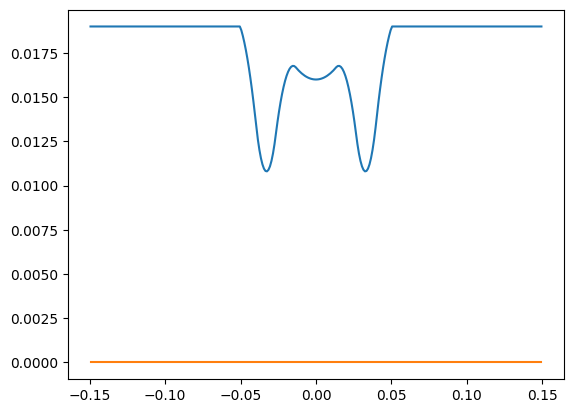

In [130]:
bar_, sections = mkCutSpline(es_state.best_member)
sections.plot(to_scale = False)

swp = xs.sweep(wood, bar_, sections, t.sweep_default)
swp.harmonics, swp.harmonics / fundamental, bar_.length


In [135]:
import optimistix
# solver = optimistix.GradientDescent(learning_rate = 0.001, rtol = 0.0000001, atol = 0.0000001)
solver = optimistix.BFGS(rtol = 1e-10, atol = 1e-10)
# solver = optimistix.NonlinearCG(rtol = 0.000001, atol = 0.000001)

solver = optimistix.BestSoFarMinimiser(solver)

# y0 = es_state.best_member

# fundamental = 440

# args = (wood, bar, fundamental, jnp.array([[0.5, 0.5], [1, -1.0], [2, 0.5], [3, -0.9], [4, 0.5], [5, -0.8]]))

sol = optimistix.minimise(lambda x,args: loss_spline(x, 0), solver = solver, y0 = es_state.best_member, max_steps = None)



(Array([ 787.55446683, 2410.38541511, 5456.50502777], dtype=float64),
 Array([1.        , 3.06059519, 6.92841607], dtype=float64),
 0.3)

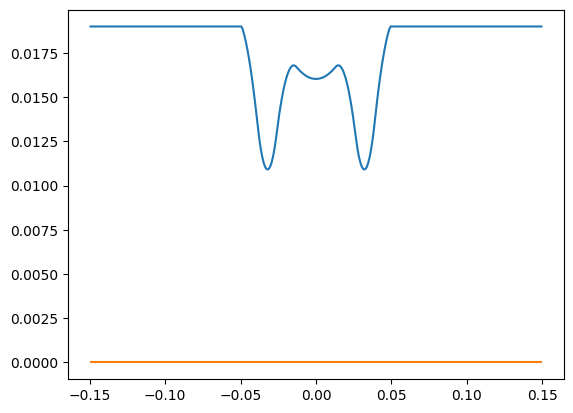

In [136]:
bar_, sections = mkCutSpline(sol.value)
sections.plot(to_scale = False)

swp = xs.sweep(wood, bar_, sections, t.sweep_default)
swp.harmonics, swp.harmonics / fundamental, bar_.length

0.0 [1081.58212829 2677.9975283  4616.38080523] [1.37334264 3.4003966  5.86166545] [1.         1.         1.         1.         0.39092797]
0.2 [1028.87660628 2667.86410791 4731.22707533] [1.30641962 3.38752965 6.00749189] [0.97236367 0.82049898 0.93592213 0.93788985 0.39092797]
0.4 [ 974.2355338  2642.01519409 4874.07065734] [1.23703893 3.3547079  6.18886802] [0.94472734 0.64099797 0.87184425 0.87577971 0.39092797]
0.6000000000000001 [ 916.75742669 2594.7581638  5046.16236528] [1.1640559  3.29470313 6.40738206] [0.91709101 0.46149695 0.80776638 0.81366956 0.39092797]
0.8 [ 855.14757805 2519.80599038 5243.83692339] [1.08582659 3.19953235 6.65838002] [0.88945468 0.28199593 0.74368851 0.75155941 0.39092797]
1.0 [ 787.55446683 2410.38541511 5456.50502777] [1.         3.06059519 6.92841607] [0.86181835 0.10249491 0.67961064 0.68944927 0.39092797]


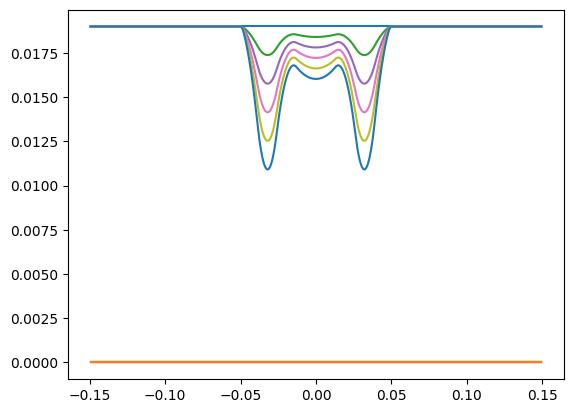

In [142]:
for i in jnp.arange(0.0, 1.1, 0.2):
    # xi = jnp.arange(1, len(sol.value) - 1)
    # ii = jnp.minimum(xi * i, 1)

    vv = xylo.cut.spline_scale(sol.value[0:-1], i)
    bar_, sections = mkCutSpline(jnp.concatenate([vv, jnp.array([sol.value[-1]])]))
    sections.plot(to_scale = False)
    
    swp = xs.sweep(wood, bar_, sections, t.sweep_default)
    print(i, swp.harmonics, swp.harmonics / fundamental, vv)

In [148]:
with open('data/spline/' + str(note) + '.json', 'w') as f:
  json.dump(sol.value.tolist(), f)